# run5 :  fold (3 classes)  mySmallNet

* img input 3x352x352 
* fold = 4
* 3 classes 
* model = myUNetSmall !!!! 

In [1]:
import sys,os
#apped depend on which machine 
paths = ['/data/solai/aiArmory/pytorch/', '/home/vlad/max78/aiArmory/pytorch/']
for path in paths:
    if os.path.exists(path):
        sys.path.append(path)
from armoInclude import *
from armoTrain import basicModel

## conf

In [2]:
# myPC
DATASET_PATH = '/data/tinyai/maxCNN/ai8x-training/data/CamVid'
MODEL_PATH = './unet_model_mySmall_x88_c3_e50_F4.pt'  
EPOCHS_TO_RUN = 50
REDO = False

# ## runServer
# DATASET_PATH = '/home/vlad/Data/CamVid'
# MODEL_PATH = '/tmp/unet_model_mySmall_x88_c3_e50_F4.pt'  
# REDO = True
# EPOCHS_TO_RUN = 50


In [3]:
INPUT_SIZE = (352, 352)
BATCH_SIZE = 8

## Model - basic reference model with no fold
NUM_CLASS   =   4   ## class+1 for none

FOLD_RATIO  =   4
NUM_CHANN   =   48  ## 3x352x352 -> 48x88x88 (fold=4) !!!!!!!!!!!!!!!!!!!!!!!!!!!!




In [4]:
runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
print(f'runDevice: {runDevice}')

runDevice: cpu


## Layers

In [5]:
class myUNetSmall(nn.Module):
    def __init__(self, num_classes=32, num_channels=48, bias=True, fold_ratio=4):
        super(myUNetSmall, self).__init__()
        self.fold_ratio = fold_ratio
        self.num_classes = num_classes
        self.num_final_channels = num_classes * fold_ratio * fold_ratio

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=bias),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.prep0 = depthwise_separable_conv(num_channels, 32, kernel_size=1, padding=0)
        self.prep1 = depthwise_separable_conv(32, 32, kernel_size=1, padding=0)
        self.prep2 = depthwise_separable_conv(32, 16, kernel_size=1, padding=0)

        self.enc1 = depthwise_separable_conv(16, 8)
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            depthwise_separable_conv(8, 16)
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            depthwise_separable_conv(16, 32)
        )

        self.bneck = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            depthwise_separable_conv(32, 64)
        )

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = depthwise_separable_conv(64, 32)

        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = depthwise_separable_conv(32, 16)

        self.upconv1 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = depthwise_separable_conv(16, 16)

        self.dec0 = depthwise_separable_conv(16, 32)

        self.conv_p1 = depthwise_separable_conv(32, 32, kernel_size=1, padding=0)
        self.conv_p2 = depthwise_separable_conv(32, 32, kernel_size=1, padding=0)
        self.conv_p3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(32)
        )

        self.conv = nn.Sequential(
            nn.Conv2d(32, self.num_final_channels, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(self.num_final_channels)
        )

    def forward(self, x):
        x = self.prep0(x)
        x = self.prep1(x)
        x = self.prep2(x)

        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        bottleneck = self.bneck(enc3)

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        dec0 = self.dec0(dec1)
        dec0 = self.conv_p1(dec0)
        dec0 = self.conv_p2(dec0)
        dec0 = self.conv_p3(dec0)
        dec0 = self.conv(dec0)

        return dec0


## data


In [6]:
filter_label = [0,5,21,17] # car sky road

In [7]:
from torchvision import transforms
from PIL import Image

class Fold:
    """
    Fold data to increase the number of channels. An interlaced approach is used in this folding
    as explained in [1].

    [1] https://arxiv.org/pdf/2203.16528.pdf
    """
    def __init__(self, fold_ratio):
        self.fold_ratio = fold_ratio
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        # Convert PIL image to tensor
        if isinstance(img, torch.Tensor):
            img_tensor = img
        else:
            img_tensor = self.to_tensor(img)

        if self.fold_ratio == 1:
            return img

        img_folded = None
        for i in range(self.fold_ratio):
            for j in range(self.fold_ratio):
                img_subsample = img_tensor[:, i::self.fold_ratio, j::self.fold_ratio]
                if img_folded is not None:
                    img_folded = torch.cat((img_folded, img_subsample), dim=0)
                else:
                    img_folded = img_subsample


        return img_folded
    


def unfold(img_batch, fold_ratio):
    """
    Unfold data to reduce the number of channels. An interlaced approach used in this folding
    as explained in [1]. This operation is the reverse of the transformation implemented
    at ai8x.fold class.

    [1] https://arxiv.org/pdf/2203.16528.pdf
    """
    if fold_ratio == 1:
        return img_batch

    num_out_channels = img_batch.shape[1] // (fold_ratio*fold_ratio)

    img_batch_uf = torch.zeros((img_batch.shape[0], num_out_channels,
                                img_batch.shape[2]*fold_ratio, img_batch.shape[3]*fold_ratio),
                               dtype=img_batch.dtype, device=img_batch.device, requires_grad=False)

    for i in range(fold_ratio):
        for j in range(fold_ratio):
            ch_index_start = num_out_channels*(i*fold_ratio + j)
            ch_index_end = num_out_channels * (i*fold_ratio + j + 1)
            img_batch_uf[:, :, i::fold_ratio, j::fold_ratio] = \
                img_batch[:, ch_index_start:ch_index_end, :, :]

    return img_batch_uf



In [8]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)])
        
        # Load class dictionary
        class_dict_path = os.path.join(DATASET_PATH, 'class_dict.csv')
        class_dict = pd.read_csv(class_dict_path)
        self.colormap = np.zeros((256**3,), dtype=int)

        if filter_label:
            print(f"...will filter classes")
            class_dict_filter = class_dict.filter(filter_label, axis=0)
        else:
            class_dict_filter = class_dict
        
        for i, row in class_dict_filter.iterrows():
            r, g, b = row['r'], row['g'], row['b']
            self.colormap[r * 256**2 + g * 256 + b] = i

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = Image.open(self.label_paths[idx]).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        
        ## RGB to categorical   = 1x352x352
        label = self.encode_segmap(np.array(label))  # Convert label to numpy array before encoding
        
        if filter_label:
            mapping = {old_value: new_index for new_index, old_value in enumerate(filter_label)}
            ## nromilize label by mapping
            label = np.vectorize(mapping.get)(label)
        
        foldOperator = Fold(FOLD_RATIO)
        label_fold = foldOperator(label) ## 16x88x88
        # unfold_label = torch.argmax(label_fold, dim=0)      ## 1x88x88 
        unfold_label, _ = torch.max(label_fold, dim=0)
        
        # ## fold after encoding
        # foldOperator = Fold(FOLD_RATIO)
        # # duplicate label to 3 channels
        # label_tensor = torch.tensor(label, dtype=torch.int64)
        # label_tensor_3ch = label_tensor.unsqueeze(0).repeat(3, 1, 1)
        # # fold label
        # label = foldOperator(label_tensor_3ch)

        return image, unfold_label

    def encode_segmap(self, mask):
        mask = mask.astype(int)
        index = mask[:, :, 0] * 256**2 + mask[:, :, 1] * 256 + mask[:, :, 2]
        return self.colormap[index]

# Step 4: Data Transformation and DataLoader
image_transform = TorchVisionTrns.Compose([
    TorchVisionTrns.Resize(INPUT_SIZE),
    Fold(FOLD_RATIO),
    TorchVisionTrns.ToTensor()
])

label_transform = TorchVisionTrns.Compose([
    TorchVisionTrns.Resize(INPUT_SIZE),
    # Fold(FOLD_RATIO),
])

train_dataset = CamVidDataset(
    image_dir=os.path.join(DATASET_PATH, 'train'),
    label_dir=os.path.join(DATASET_PATH, 'train_labels'),
    image_transform=image_transform,
    label_transform=label_transform
)

val_dataset = CamVidDataset(
    ## change to have more data in val then in test
    image_dir=os.path.join(DATASET_PATH, 'test'),
    label_dir=os.path.join(DATASET_PATH, 'test_labels'),
    image_transform=image_transform,
    label_transform=label_transform
)

test_dataset = CamVidDataset(
    ## change to have more data in val then in test
    image_dir=os.path.join(DATASET_PATH, 'val'),
    label_dir=os.path.join(DATASET_PATH, 'val_labels'),
    image_transform=image_transform,
    label_transform=label_transform
)

dlTrain = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dlVal = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
dlTest = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



...will filter classes
...will filter classes
...will filter classes


/data/solai/venvMamabaFixel/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
print(f"train_loader len =  {len(dlTrain.dataset)}")
print(f"val_loader len =  {len(dlVal.dataset)}")
print(f"test_loader len =  {len(dlTest.dataset)}")

train_loader len =  100
val_loader len =  100
test_loader len =  100


# model

In [10]:
oModel = myUNetSmall(num_classes=NUM_CLASS, num_channels=NUM_CHANN, bias=True, fold_ratio=FOLD_RATIO)
oModel = oModel.to(runDevice)
myTrain = basicModel(model=oModel,CheckpointFile=MODEL_PATH)

### loss

In [11]:
hL = nn.CrossEntropyLoss()
hL = hL.to(runDevice)

### score

In [12]:
# Given the shape of outputs is [8, 32, 80, 80], 
# applying torch.max(outputs, 1) will reduce the dimension
# from 32 to 1 by finding the maximum value along the
# second dimension (dim=1). 
# vals:  will be The maximum values along the specified dimension (dim=1) 
# preds: The indices of the maximum values along the specified dimension
#         with shape of preds will be [8, 80, 80].

def hS(outputs, labels):
    vals , preds = torch.max(outputs, 1)
    corrects = torch.sum(preds.data == labels.data)
    return corrects.double() / labels.numel()


### optimizer

In [13]:
oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 1e-5)

### scheduler

In [14]:
oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-4, total_steps = EPOCHS_TO_RUN)


### summary

In [15]:
myTrain.verify( dlTrain, dlVal, oOpt, EPOCHS_TO_RUN , BATCH_SIZE , hL, hS, oSch = oSch)


=======================  info   =========================================================
numEpoch = 50 ; batchSize = 8
Train: 
    len train dataset 100 / batchSize  8 = len Train 13 
    dlTrain: iter tX shape   = torch.Size([8, 48, 88, 88]) 
    dlTrain: iter vY ; shape = torch.Size([8, 88, 88])
Val: 
    dlVal  : tensor[0].shape = torch.Size([8, 48, 88, 88])
    dlVal  : tensor[1].shape = torch.Size([8, 88, 88])
=======================  summary   =========================================================
Layer (type:depth-idx)                   Output Shape              Param #
myUNetSmall                              [8, 64, 88, 88]           --
├─Sequential: 1-1                        [8, 32, 88, 88]           --
│    └─Conv2d: 2-1                       [8, 48, 88, 88]           96
│    └─BatchNorm2d: 2-2                  [8, 48, 88, 88]           96
│    └─ReLU: 2-3                         [8, 48, 88, 88]           --
│    └─Conv2d: 2-4                       [8, 32, 88, 88]      

# train

In [16]:
## train or load:
if REDO == True:
    trained = myTrain.TrainModel(dlTrain, dlVal, oOpt, EPOCHS_TO_RUN, hL, hS, oSch = oSch)
else:
    trained = myTrain.loadModel(MODEL_PATH)

model loaded from ./unet_model_mySmall_x88_c3_e50_F4.pt


## results

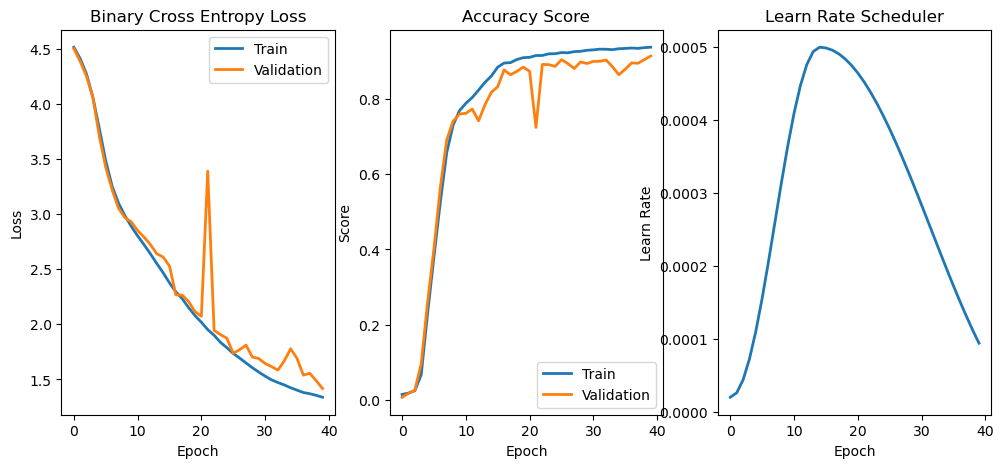

In [17]:
myTrain.plotTrainResults()

## loss on test

In [18]:
test_score = myTrain.evaluate_test_data(testData = dlTest ,score_fn=hS)

Test Score: 0.9289164315797839


## test case examine

Unique values in the raw output: [-1.6643046 -1.6031445 -1.602401  ... 12.445987  12.658648  12.721593 ]
Unique values in the predicted segmentation: [0 1 2 3]


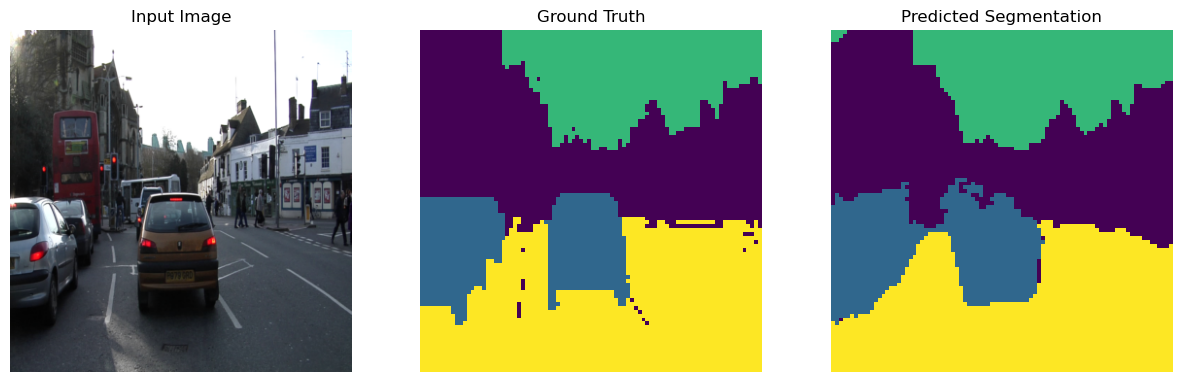

In [19]:


def visualize_prediction(model, dataset, index):
    model.eval()
    image, label = dataset[index]
    image = image.unsqueeze(0)  
    unfold_img=unfold(image, FOLD_RATIO)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).cpu().squeeze(0)  # Remove batch dimension and move to CPU

    # Debugging: Check unique values in the output and prediction
    print("Unique values in the raw output:", np.unique(output.cpu().numpy()))
    print("Unique values in the predicted segmentation:", np.unique(pred.numpy()))

    # Convert the tensors to images for visualization
    unfold_img = unfold_img.cpu().squeeze(0).permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    label = label.cpu()
    pred = pred.cpu()

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(unfold_img)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(label)
    ax[1].set_title('Ground Truth')
    ax[1].axis('off')

    ax[2].imshow(pred)
    ax[2].set_title('Predicted Segmentation')
    ax[2].axis('off')

    plt.show()

# Visualize prediction on a sample image from the validation set
visualize_prediction(myTrain.model, val_dataset, index=1)

## new test

orig image.size = (960, 720)
image.size = (960, 720)


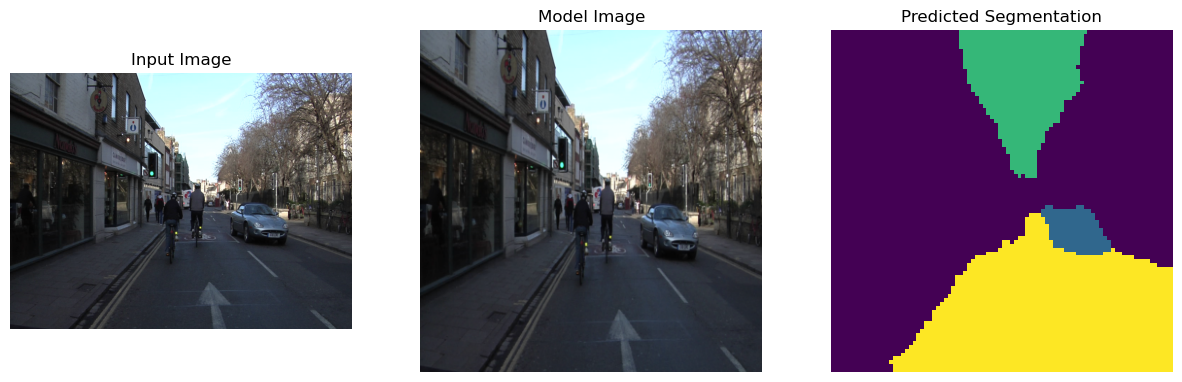

orig image.size = (721, 1600)
image.size = (960, 720)


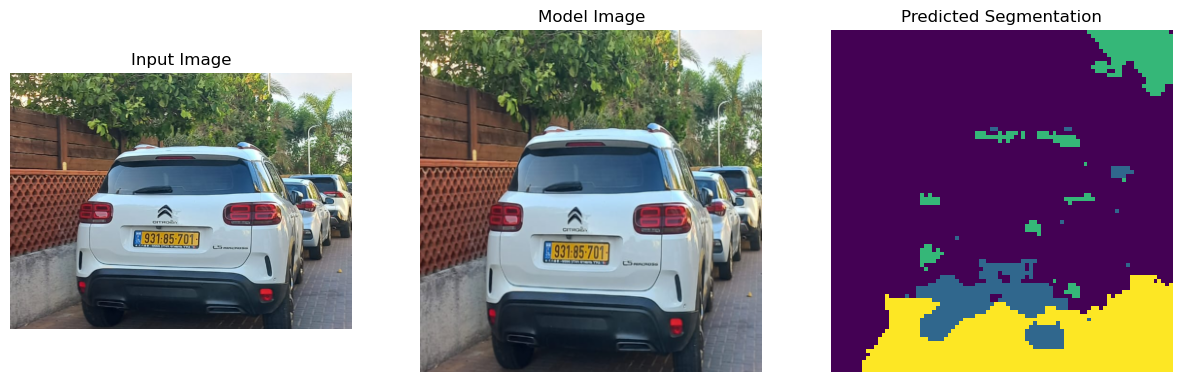

orig image.size = (400, 300)
image.size = (960, 720)


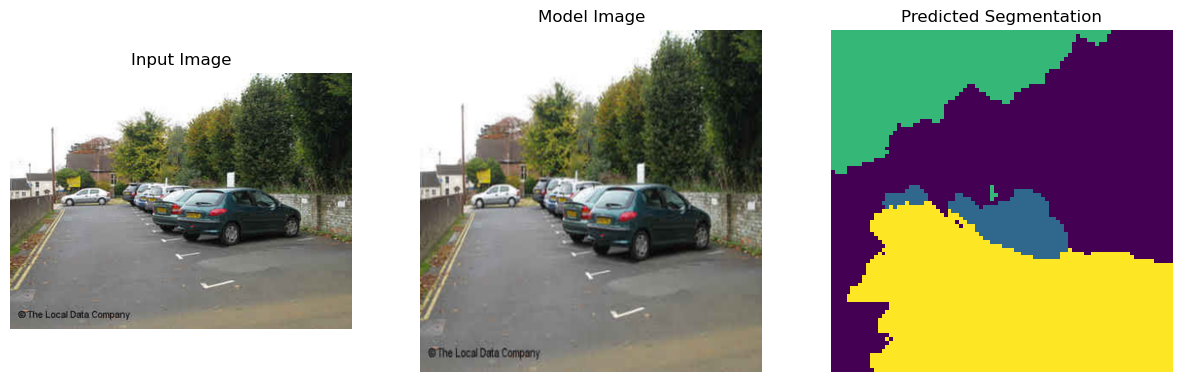

In [20]:
from PIL import Image, ImageOps

def visualize_new_prediction(model,new_image_path):
    if not os.path.exists(new_image_path):
        return None
    model.eval()
    image = Image.open(new_image_path).convert('RGB')
    
    ## make the same size as the training image
    print(f"orig image.size = {image.size}")
    test_size = (960, 720)
    image = ImageOps.fit(image, test_size, method=Image.LANCZOS)
    print(f"image.size = {image.size}")
    


    
    image_tensor = image_transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).cpu().squeeze(0)  # Remove batch dimension and move to CPU
    
    # Convert the tensor image to numpy for visualization
    image_tensor = unfold(image_tensor, FOLD_RATIO)
    image_model = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    
    ax[1].imshow(image_model)
    ax[1].set_title('Model Image')
    ax[1].axis('off')

    ax[2].imshow(pred)
    ax[2].set_title('Predicted Segmentation')
    ax[2].axis('off')

    plt.show()

visualize_new_prediction(myTrain.model,'/home/vlad/Data/myTestImg/carPark1.jpeg')    
visualize_new_prediction(myTrain.model,'/data/tinyai/maxCNN/ai8x-training/data/CamVid/test/0016E5_08025.png')    
visualize_new_prediction(myTrain.model,'/data/solai/projB/1_unteSmall/results/carPark1.jpeg')    
visualize_new_prediction(myTrain.model,'/data/solai/projB/1_unteSmall/results/newTest1.jpg')    

# report

In [21]:
print(f"trainning   : EPOCHS_TO_RUN={EPOCHS_TO_RUN} ; batch={BATCH_SIZE}")
print(f"model       : file={MODEL_PATH}")
print(f"input data  : train_len =  {len(dlTrain.dataset)} ; test_len={len(dlVal.dataset)} ; val_len={len(dlTest.dataset)} ")
print(f"img input   : INPUT_SIZE={INPUT_SIZE}")
print(f"model       : NUM_CLASS={NUM_CLASS} ; NUM_CHANN={NUM_CHANN} ; FOLD_RATIO={FOLD_RATIO}")
print(f"score       : val_score={myTrain.lValScore[-1]} ; val_loss {myTrain.lValLoss[-1]}")
print(f"            : test_score={test_score}")
print(f"Trainable parameters: {myTrain.parma_stat()['trainable_params']}")
print(f"parameters_size_in_megabytes : {myTrain.parma_stat()['total_size_in_megabytes']}")

trainning   : EPOCHS_TO_RUN=50 ; batch=8
model       : file=./unet_model_mySmall_x88_c3_e50_F4.pt
input data  : train_len =  100 ; test_len=100 ; val_len=100 
img input   : INPUT_SIZE=(352, 352)
model       : NUM_CLASS=4 ; NUM_CHANN=48 ; FOLD_RATIO=4
score       : val_score=0.9131630272157311 ; val_loss 1.4180119119841477
            : test_score=0.9289164315797839
Trainable parameters: 43056
parameters_size_in_megabytes : 0.16424560546875
